In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
NFFT = 1024
SAMPLE_RATE = 2_048_000
H21 = 1.420405751768e9  # Hz

METERS_PER_PARSEC = 3.0857e16
EARTH_GALACTIC_CENTER = 8.5  # kpc, IAU
V0 = 220e3  # m/s, source: IAU apparently, unable to find
OORT_A = ufloat(15.3e3, 0.4e3)  # m s−1 kpc−1

In [4]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [5]:
data = []
noise = None
freq = None

files = sorted(glob("../data/h_*.dat"))
files.sort(key=os.path.getmtime)

for file in files:
    _, (spectrum, freq), params = load(file)
    params['l'] = ufloat(file.split('data/h_')[1].split('_')[0], 1)
    data.append((spectrum, params))

_, (noise, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")

In [6]:
def gaussian(x: np.ndarray, A: float, B: float, mu: float, sigma: float) -> np.ndarray:
    return A + B * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [7]:
def deg2rad(deg: float | Variable) -> float | Variable:
    return np.pi * deg / 180

In [8]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [9]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [10]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [11]:
def calculate_relative_velocity(measured_frequency: float | Variable) -> float | Variable:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [12]:
def bad_distance_estimate(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A / unp.sin(2 * galactic_rad)
    return abs(d)

In [13]:
def velocity_vector_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(EARTH_GALACTIC_CENTER**2 + d**2 - 2 * EARTH_GALACTIC_CENTER * d * unp.cos(galactic_rad))

    V_hydrogen_cloud = R / EARTH_GALACTIC_CENTER * (relative_velocity / unp.sin(galactic_rad) + V0)
    return V_hydrogen_cloud, R

In [14]:
def matteo_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(EARTH_GALACTIC_CENTER**2 + d**2 - 2 * EARTH_GALACTIC_CENTER * d * unp.cos(galactic_rad))

    cos_alpha = (R**2 + d**2 - EARTH_GALACTIC_CENTER**2) / (2 * R * d)
    V_hydrogen_cloud = (relative_velocity + V0 * unp.sin(galactic_rad)) / unp.sqrt(1 - cos_alpha**2)
    return V_hydrogen_cloud, R

In [24]:
def do_the_processing_mate(freq: np.ndarray, spectrum: np.ndarray, params: dict, noise: np.ndarray, peaks_idx: list[int] = None, display: bool = True) -> Variable:
    cleaned_signal = clean_up(normalise_data(spectrum, noise), w=5)
    
    if peaks_idx is None:
        max_idx = np.argmax(cleaned_signal)
        freq_of_max = ufloat(freq[max_idx], 0.00002e9)  # estimated error based on vibes
        print(f"Maximum found at {freq[max_idx]} Hz")
    else:
        if len(peaks_idx) > 1: print("WARNING: only uses the first value currently")
        freq_of_max = ufloat(freq[peaks_idx[0]], 0.00002e9)  # estimated error based on vibes

    relative_velocity = calculate_relative_velocity(freq_of_max)
    
    l: float = params.get('l', 0)
    actual_velocity: Variable = None
    radius: Variable = None
    # Inner circle
    if l < 90:
        actual_velocity, radius = velocity_vector_method(relative_velocity, l)
    # Outer circle
    elif l < 270:
        print(f"WARNING: using the bad method for {l=:.0f}")
        actual_velocity, radius = matteo_method(relative_velocity, l)

    if display:
        print(f"Estimated relative velocity ({l=:.1uP}): {relative_velocity/1000:.3upP} km/s")
        print(f"Estimated actual velocity ({l=:.1uP}): {actual_velocity/1000:.3upP} km/s")
        plt.semilogy(freq, cleaned_signal)
        plt.axvline(H21, c='r', label='Base H21', ls='--')
        plt.axvline(freq_of_max.n, c='magenta', label='Shifted peak')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Signal-to-noise ratio")
        plt.legend()
    
    distance_est = bad_distance_estimate(relative_velocity, l)

    return distance_est, actual_velocity, radius, l

Spectrum [0]
Maximum found at 1420488000.0 Hz
Estimated relative velocity (l=3±1): (-17.36±4.22) km/s
Estimated actual velocity (l=3±1): (-31.6±96.1) km/s


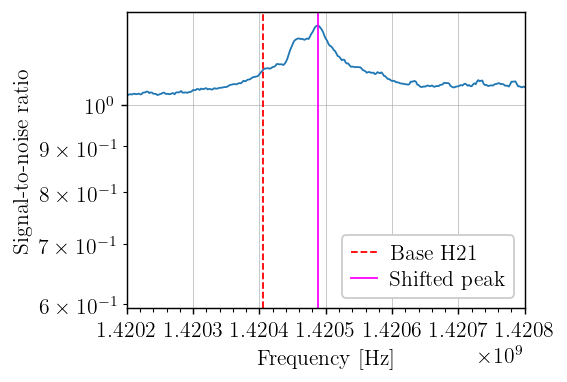

Spectrum [1]
Maximum found at 1420482000.0 Hz
Estimated relative velocity (l=6±1): (-16.09±4.22) km/s
Estimated actual velocity (l=6±1): (27.3±31.6) km/s


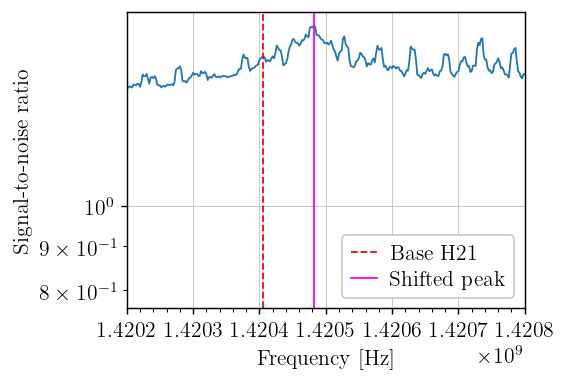

Spectrum [2]
Maximum found at 1420484000.0 Hz
Estimated relative velocity (l=9±1): (-16.51±4.22) km/s
Estimated actual velocity (l=9±1): (68.4±30.2) km/s


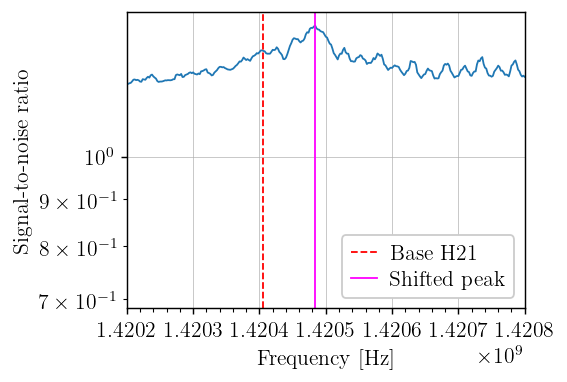

Spectrum [3]
Maximum found at 1420484000.0 Hz
Estimated relative velocity (l=12±1): (-16.51±4.22) km/s
Estimated actual velocity (l=12±1): (98.1±26.2) km/s


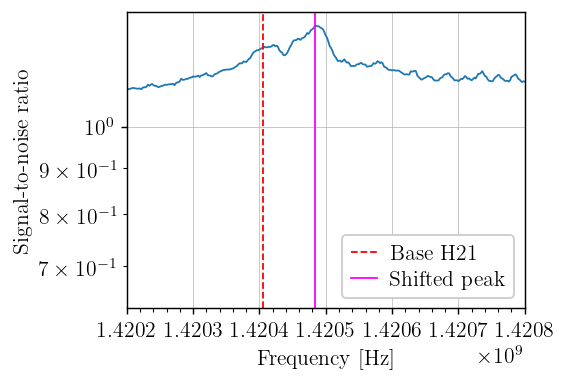

Spectrum [4]
Maximum found at 1420490000.0 Hz
Estimated relative velocity (l=15±1): (-17.78±4.22) km/s
Estimated actual velocity (l=15±1): (111.9±22.1) km/s


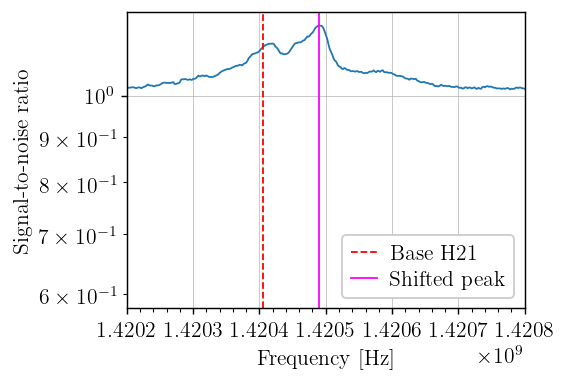

Spectrum [5]
Maximum found at 1420490000.0 Hz
Estimated relative velocity (l=18±1): (-17.78±4.22) km/s
Estimated actual velocity (l=18±1): (127.1±19.4) km/s


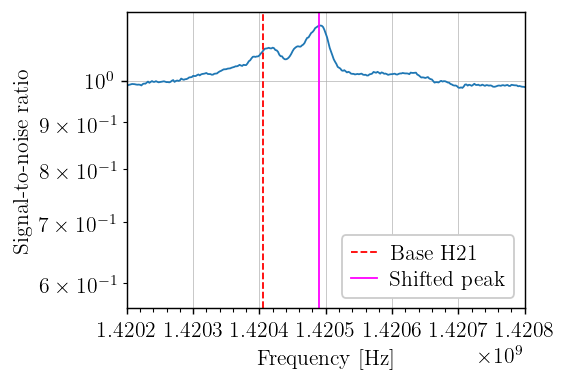

Spectrum [6]
Maximum found at 1420492000.0 Hz
Estimated relative velocity (l=21±1): (-18.20±4.22) km/s
Estimated actual velocity (l=21±1): (136.8±17.2) km/s


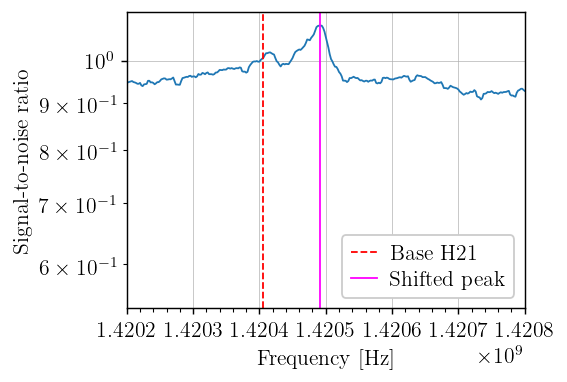

Spectrum [7]
Maximum found at 1420484000.0 Hz
Estimated relative velocity (l=24±1): (-16.51±4.22) km/s
Estimated actual velocity (l=24±1): (151.9±15.9) km/s


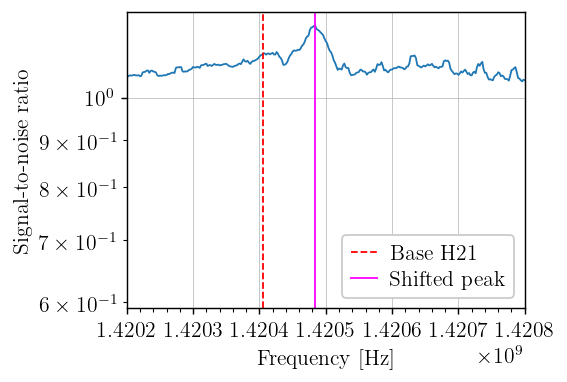

Spectrum [8]
Maximum found at 1420484000.0 Hz
Estimated relative velocity (l=27±1): (-16.51±4.22) km/s
Estimated actual velocity (l=27±1): (158.5±14.4) km/s


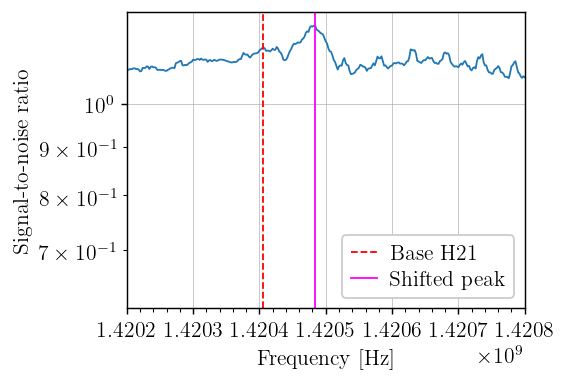

Spectrum [9]
Maximum found at 1420484000.0 Hz
Estimated relative velocity (l=30±1): (-16.51±4.22) km/s
Estimated actual velocity (l=30±1): (163.8±13.3) km/s


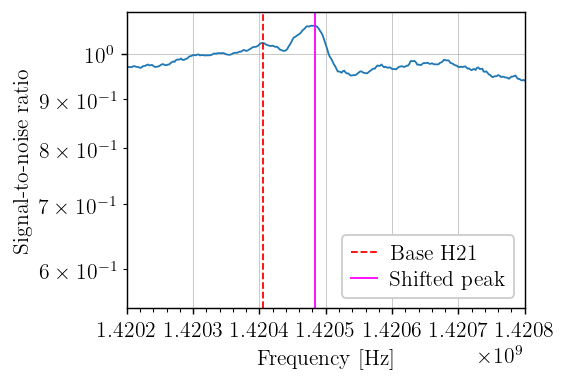

Spectrum [10]
Maximum found at 1420472000.0 Hz
Estimated relative velocity (l=33±1): (-13.98±4.22) km/s
Estimated actual velocity (l=33±1): (175.6±12.6) km/s


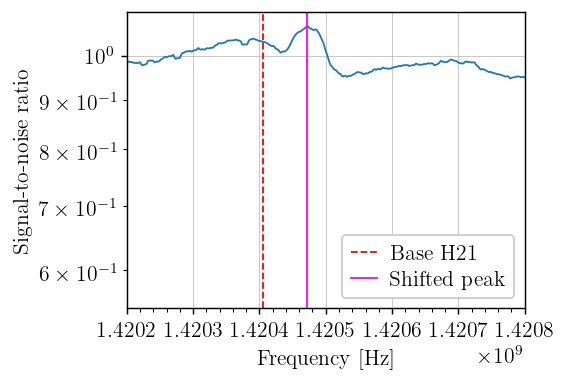

Spectrum [11]
Maximum found at 1420476000.0 Hz
Estimated relative velocity (l=36±1): (-14.83±4.22) km/s
Estimated actual velocity (l=36±1): (176.4±11.6) km/s


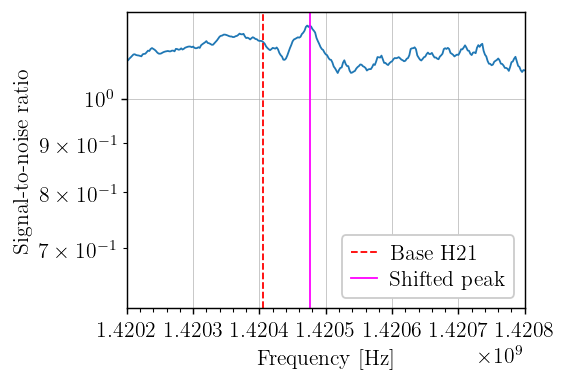

Spectrum [12]
Maximum found at 1420472000.0 Hz
Estimated relative velocity (l=39±1): (-13.98±4.22) km/s
Estimated actual velocity (l=39±1): (181.4±11.0) km/s


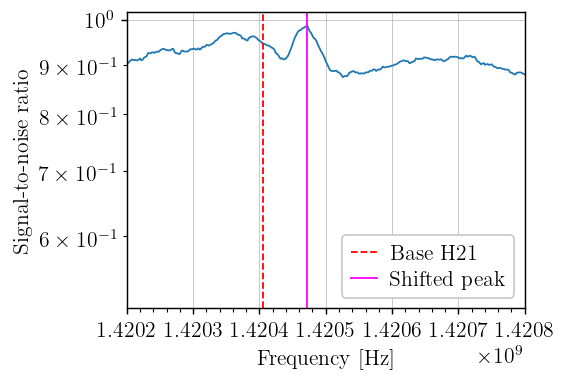

Spectrum [13]
Maximum found at 1420472000.0 Hz
Estimated relative velocity (l=42±1): (-13.98±4.22) km/s
Estimated actual velocity (l=42±1): (183.7±10.3) km/s


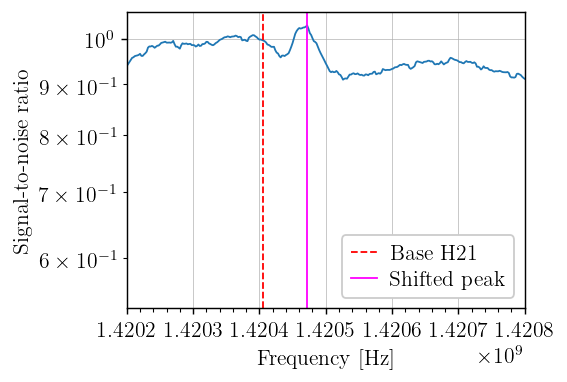

Spectrum [14]
Maximum found at 1420460000.0 Hz
Estimated relative velocity (l=45±1): (-11.45±4.22) km/s
Estimated actual velocity (l=45±1): (191.54±9.98) km/s


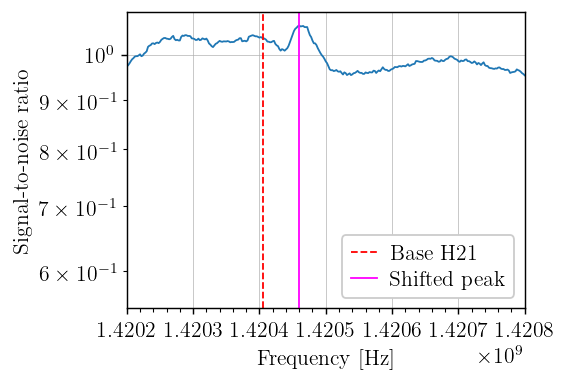

Spectrum [15]
Maximum found at 1420458000.0 Hz
Estimated relative velocity (l=48±1): (-11.03±4.22) km/s
Estimated actual velocity (l=48±1): (193.89±9.52) km/s


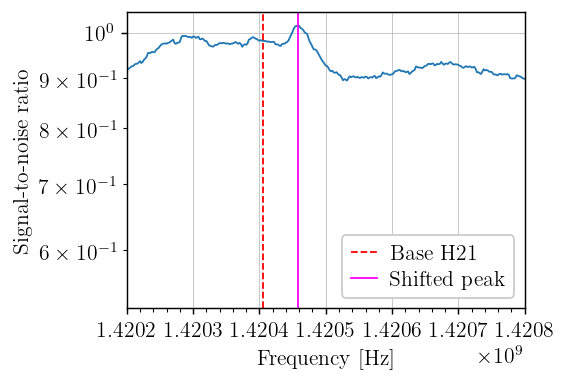

Spectrum [16]
Maximum found at 1420454000.0 Hz
Estimated relative velocity (l=51±1): (-10.18±4.22) km/s
Estimated actual velocity (l=51±1): (196.90±9.14) km/s


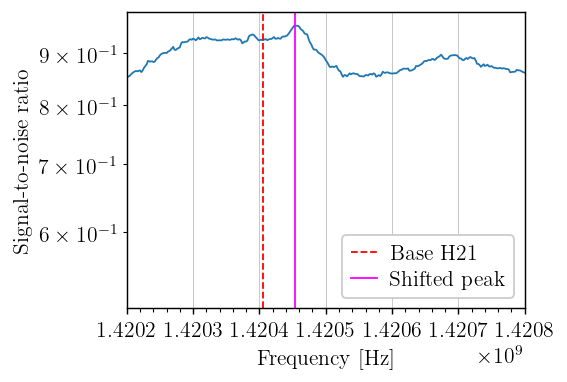

Spectrum [22]
Maximum found at 1420426000.0 Hz
Estimated relative velocity (l=66±1): (-4.27±4.22) km/s
Estimated actual velocity (l=66±1): (211.63±8.01) km/s


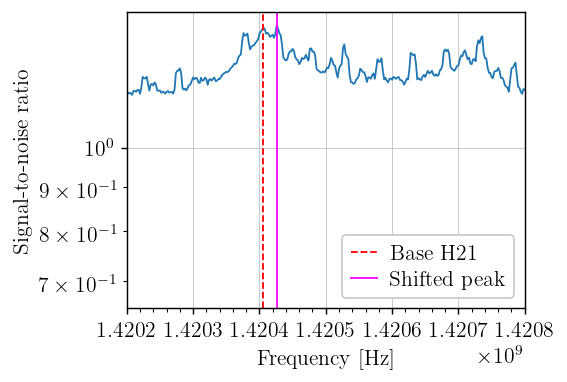

Spectrum [23]
Maximum found at 1420406000.0 Hz
Estimated relative velocity (l=69±1): (-0.05±4.22) km/s
Estimated actual velocity (l=69±1): (219.90±8.34) km/s


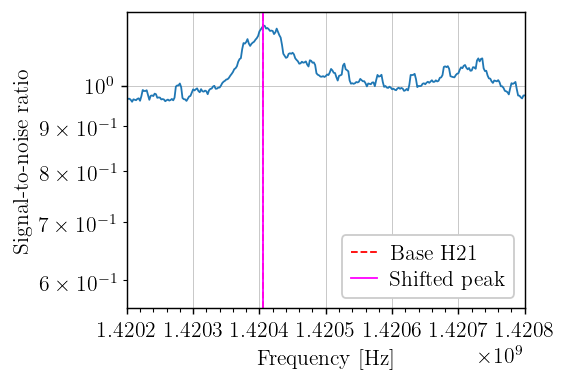

Spectrum [27]
Maximum found at 1420376000.0 Hz
Estimated relative velocity (l=81±1): (6.28±4.22) km/s
Estimated actual velocity (l=81±1): (223.57±4.26) km/s


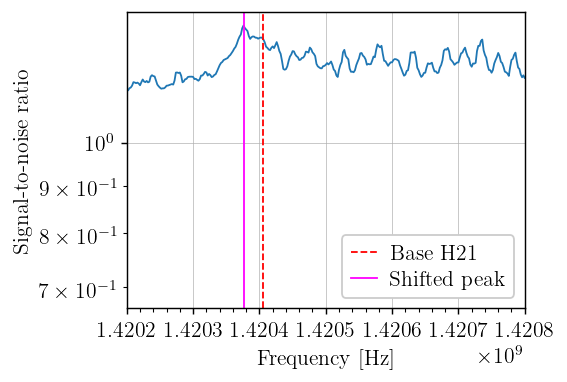

Spectrum [32]
Maximum found at 1420374000.0 Hz
Estimated relative velocity (l=99±1): (6.70±4.22) km/s
Estimated actual velocity (l=99±1): (235.7±11.9) km/s


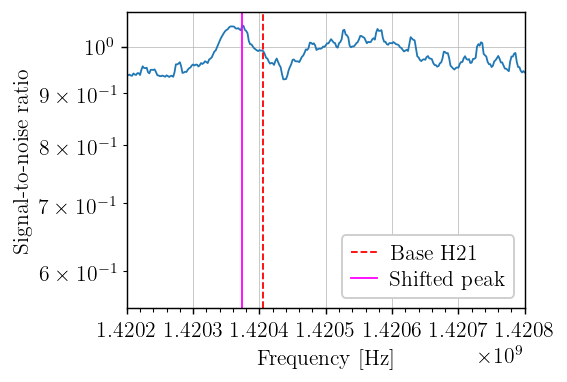

Spectrum [33]
Maximum found at 1420354000.0 Hz
Estimated relative velocity (l=102±1): (10.92±4.22) km/s
Estimated actual velocity (l=102±1): (245.6±11.8) km/s


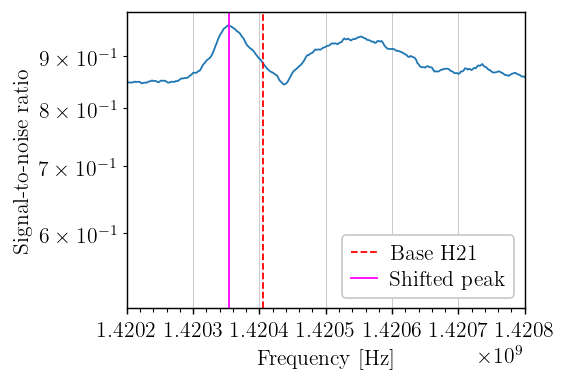

Spectrum [34]
Maximum found at 1420346000.0 Hz
Estimated relative velocity (l=105±1): (12.61±4.22) km/s
Estimated actual velocity (l=105±1): (248.6±11.1) km/s


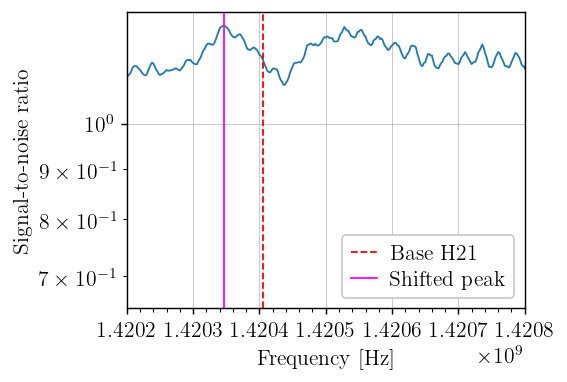

In [35]:
all_peaks = [None] * len(data)
all_peaks[19] = [725]
all_peaks[20] = [725]

ignore = np.full(len(data), False)
ignore[17:22] = True
ignore[24:27] = True
ignore[28:32] = True
ignore[35:] = True

distances = []
velocities = []
longitudes = []
radii = []


for i, ((spectrum, params), peaks) in enumerate(zip(data, all_peaks)):
    if (ignore[i]):
        distances.append(None)
        velocities.append(None)
        longitudes.append(None)
        radii.append(None)
    else:
        print(f"Spectrum [{i}]")
        dist, vel , radius, l = do_the_processing_mate(freq, spectrum, params, noise, peaks_idx=peaks)
        distances.append(dist)
        velocities.append(vel)
        longitudes.append(l)
        radii.append(radius)
        plt.xlim(1.4202e9, 1.4208e9)
        plt.show()

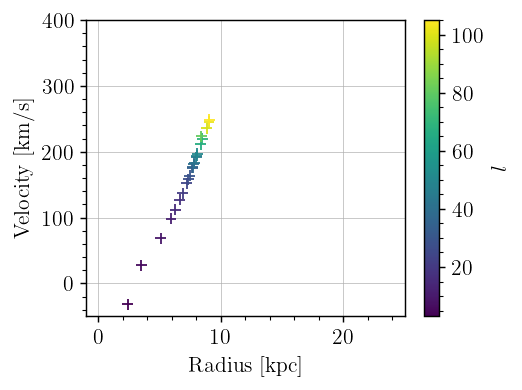

In [39]:
plt.scatter([nom_vals(R) for R in radii if R is not None], [v.n / 1000 for v in velocities if v is not None], c = [l.n for l in longitudes if l is not None])

plt.xlim(-1,25)
plt.ylim(-50,400)

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")

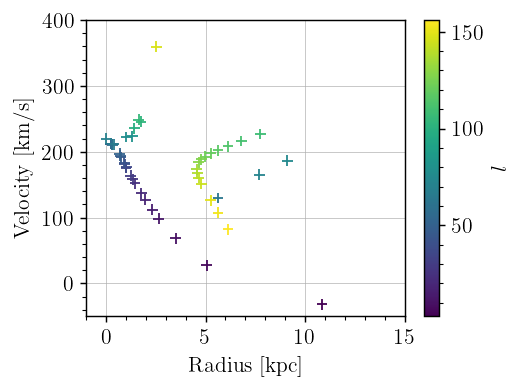

In [ ]:
plt.scatter([d.n for d in distances], [v.n / 1000 for v in velocities], c = [l.n for l in longitudes])

plt.xlim(-1,15)
plt.ylim(-50,400)

plt.xlabel('Distance from Sun [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")

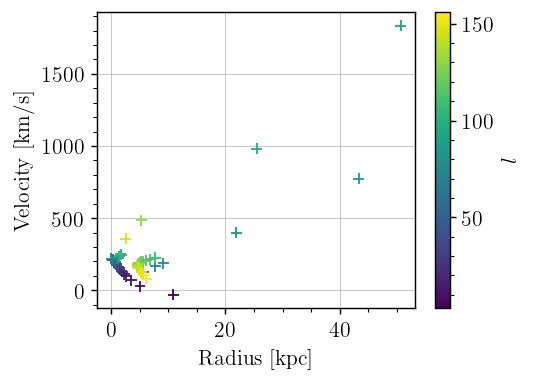

In [ ]:
plt.scatter([d.n for d in distances], [v.n / 1000 for v in velocities], c = [l.n for l in longitudes])

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")